# PREDICTIONS

TODOs
- Try MAPE and MASE as metrics
- Conformal Predictions 

## 0. Setup and Configuration

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

import sys
import os
sys.path.append(os.path.abspath('..'))


from src.data import load_data, download_data, compute_features
from src.lstm import train_lstm, evaluate_lstm
from utils.tscv import run_tscv, run_fixed_window_tscv, run_lstm_tscv


# Set seeds for reproducibility
random_state = 42
torch.manual_seed(random_state)
np.random.seed(random_state)

# Global Variables
TRADING_WEEK = 5
TRADING_MONTH = 21
TRADING_YEAR = 252

In [2]:
feature_cols = [
    "LogReturn",
    "RealisedVolatility",
    "RSI_14",
    "BB_Width",
    "MACD",
    "YZVolatility",
    "Log_CO",
    "Log_HL",
]
ticker = "TSLA"
start_date = "2015-01-01"
seq_len = 30

In [3]:
(X_train, y_train, dates_train), (X_val, y_val, dates_val), (X_test, y_test, dates_test) = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.7,
    test_size=0.15,
)
# Print shapes of the datasets
print(f"Train shape: {len(X_train)}")
print(f"\t Train X shape: {X_train.shape}")
print(f"\t Train y shape: {y_train.shape}")
print(f"\t Train dates shape: {dates_train.shape}")
print(f"Validation shape: {len(X_val) if X_val is not None else 0}")
print(f"Test shape: {len(X_test)}\n")

# Print date ranges
print(f"Train dates:      {dates_train[0]} to {dates_train[-1]}")
if X_val is not None:
    print(f"Validation dates: {dates_val[0]} to {dates_val[-1]}")
print(f"Test dates:       {dates_test[0]} to {dates_test[-1]}")

[*********************100%***********************]  1 of 1 completed

Train shape: 1887
	 Train X shape: (1887, 30, 8)
	 Train y shape: (1887,)
	 Train dates shape: (1887,)
Validation shape: 404
Test shape: 405

Train dates:      2015-03-18 to 2022-09-13
Validation dates: 2022-09-14 to 2024-04-23
Test dates:       2024-04-24 to 2025-12-03


## 1. Explotary Analysis

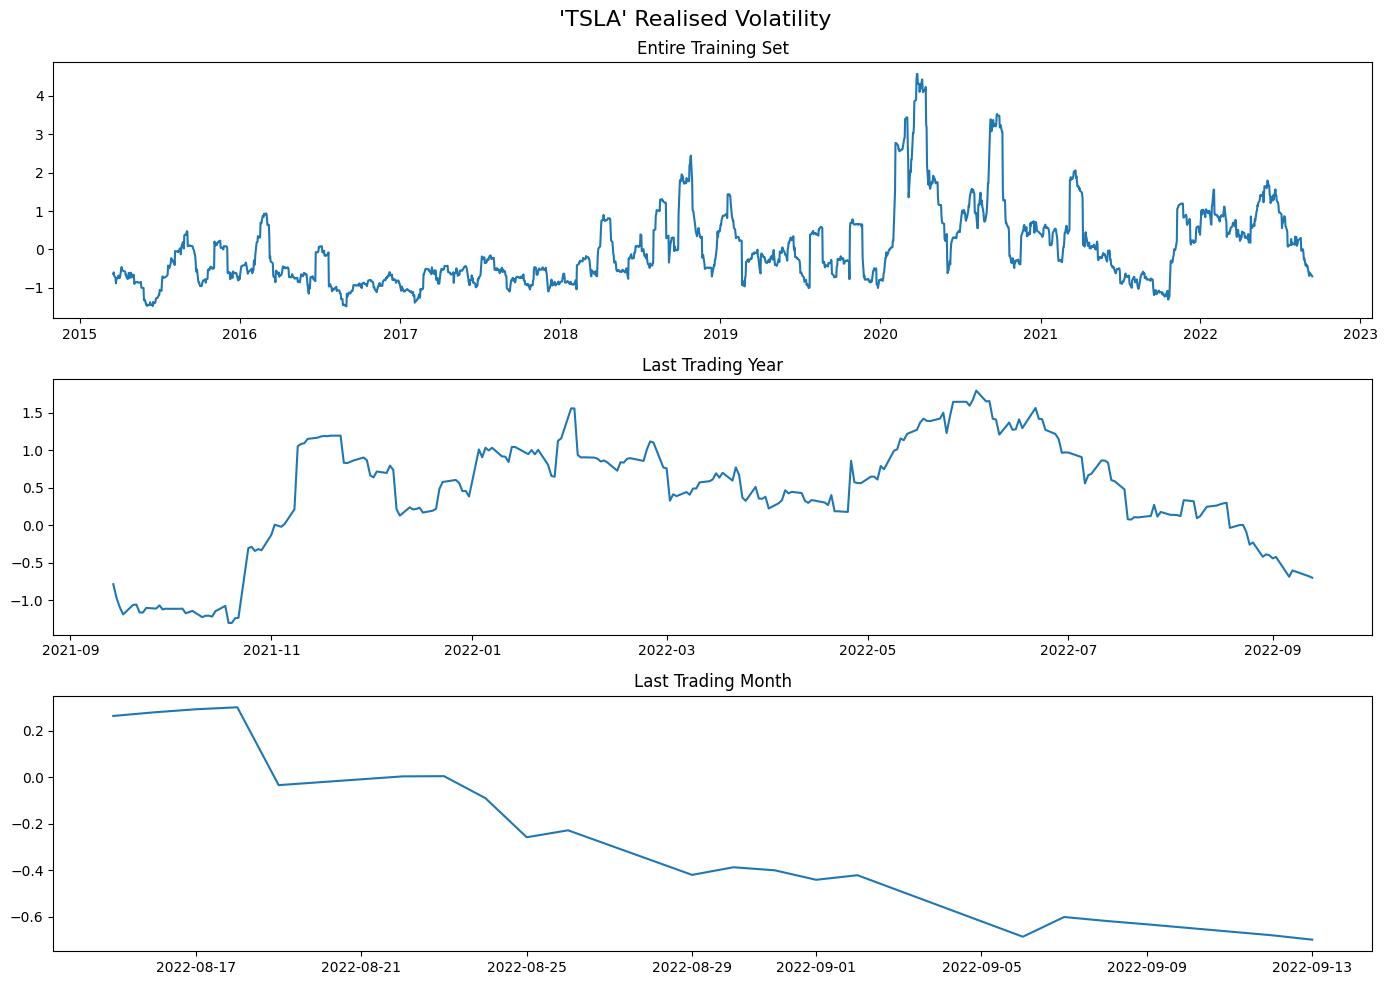

In [4]:
# 2) Basic plots: entire series, one month, a couple of days
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
# Title for the entire figure
fig.suptitle(f'\'{ticker}\' Realised Volatility', fontsize=16)
# Plot entire training set
ax[0].plot(dates_train, y_train, label='Realised Volatility')
ax[0].set_title('Entire Training Set')
# Zoom into last trading year (last available in training set)
ax[1].plot(dates_train[-TRADING_YEAR:], y_train[-TRADING_YEAR:], label='Realised Volatility')
ax[1].set_title('Last Trading Year')
# Zoom into last month
ax[2].plot(dates_train[-TRADING_MONTH:], y_train[-TRADING_MONTH:], label='Realised Volatility')
ax[2].set_title('Last Trading Month')
plt.tight_layout()
plt.show()

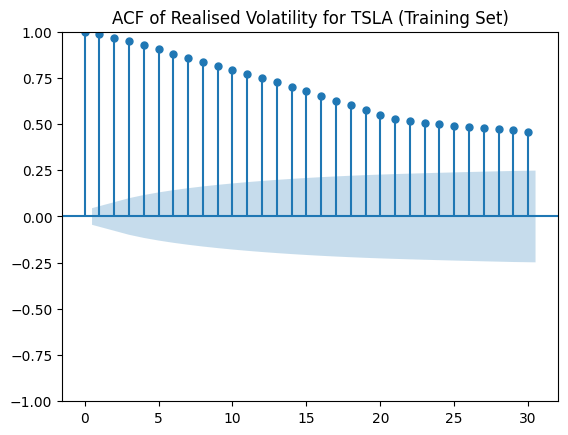

In [5]:
# Plot ACF of the target variable in the training set
plot_acf(y_train, lags=30)
plt.title(f'ACF of Realised Volatility for {ticker} (Training Set)')
plt.show()

## 2. Baseline Models
### 2.1 Naive Model

Naive Baseline:
	'Test' MAE:  0.101513
	'Test' RMSE: 0.217482


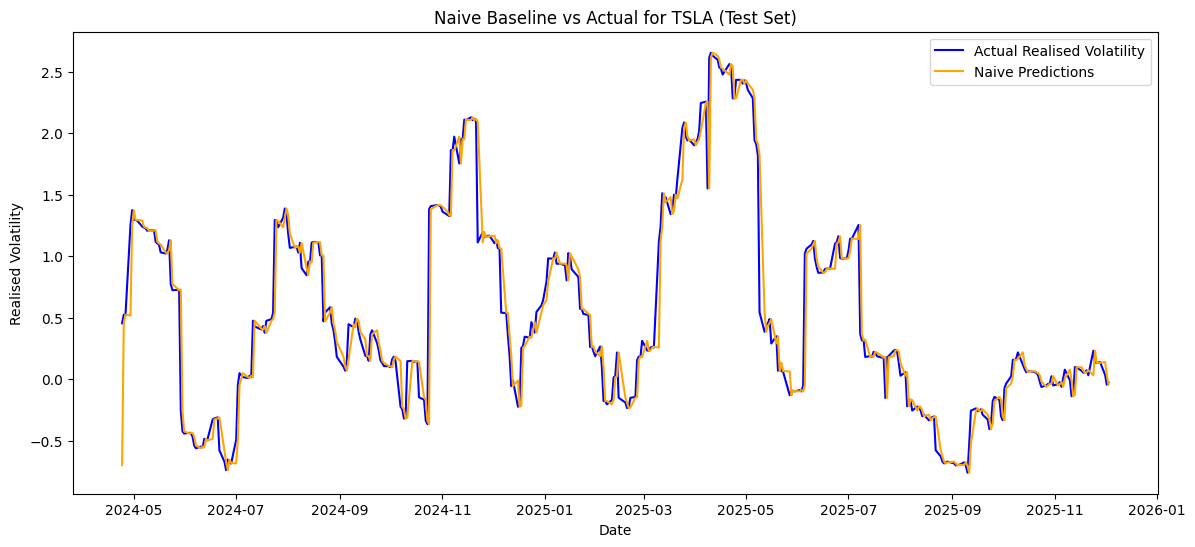

In [6]:
# naive: y_pred[t] = y[t-1]
base_preds = np.empty_like(y_test)

# first test prediction = last training value
base_preds[0] = y_train[-1]

# the rest use previous test values
base_preds[1:] = y_test[:-1]

base_mae = mean_absolute_error(y_test, base_preds)
base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))

print(f"Naive Baseline:")
print(f"\t'Test' MAE:  {base_mae:.6f}")
print(f"\t'Test' RMSE: {base_rmse:.6f}")

# Plot naive predictions vs actuals
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual Realised Volatility', color='blue')
plt.plot(dates_test, base_preds, label='Naive Predictions', color='orange')
plt.title(f'Naive Baseline vs Actual for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

Such low values of MAE and RMSE might seem surprising, but if we look at the autocorrelation coefficient of the 1st lag below (also seen in the ACF plot), we can see that there is a very high correlation (0.99) between the current value and the previous value. This means that using the previous value as a prediction is quite effective in this case.

In [7]:
print(f"Autocorrelation Coefficient for lag 1 = {pd.Series(y_train.ravel()).autocorr(lag=1):.4f}")

Autocorrelation Coefficient for lag 1 = 0.9851


### 2.2 HAR-RV

Heterogenous Autoregressive Model for Realized Volatility (HAR-RV) is frequently used to model and forecast realized volatility. The HAR-RV model captures the long-memory property of volatility by incorporating realized volatility over different time horizons (daily, weekly, monthly) as predictors.

1. Intuition:
    Core idea: financial markets are heterogeneous, with participants operating on different time scales (short, medium and long-term traders)
2. Model Specification:
    The HAR-RV model can be expressed mathematically as:
    $$
    RV_{t+1} = \beta_0 + \beta_d RV_t^{(d)} + \beta_w RV_t^{(w)} + \beta_m RV_t^{(m)} + \epsilon_{t+1}
    $$
    Where:
    - $RV_t^{(d)} = RV_t$ is yesterday's RV.
    - $RV_t^{(w)} = \frac{1}{5} \sum_{i=0}^{4} RV_{t-i}$ is the average RV over the past week.
    - $RV_t^{(m)} = \frac{1}{22} \sum_{i=0}^{21} RV_{t-i}$ is the average RV over the past month.
    - $\beta_0, \beta_d, \beta _w, \beta_m$ are the model coefficients to be estimated.

In [8]:
rv = pd.Series(y_train.ravel(), index=dates_train)
rv_test = pd.Series(y_test.ravel(), index=dates_test)
full_rv = pd.concat([rv, rv_test])

lags = [1, 5, 22]  # daily, weekly, monthly
# Daily Lag
full_rv_lag0 = full_rv.shift(lags[0])

# Weekly Lag
full_rv_lag1 = full_rv.rolling(window=lags[1]).mean().shift(1)

# Monthly Lag
full_rv_lag2 = full_rv.rolling(window=lags[2]).mean().shift(1)

har_data = pd.DataFrame({
    'RV': full_rv,
    f'RV_Lag{lags[0]}': full_rv_lag0,
    f'RV_Lag{lags[1]}': full_rv_lag1,
    f'RV_Lag{lags[2]}': full_rv_lag2,
}).dropna()

train_len = len(rv)  # index to split train/test
rows_dropped = len(full_rv) - len(har_data)  # rows dropped due to NaNs
split_point_in_har = train_len - rows_dropped  # adjust split index
har_train = har_data.iloc[:split_point_in_har]
har_test = har_data.iloc[split_point_in_har:]

In [9]:
import statsmodels.api as sm

lag_names = [f"RV_Lag{lag}" for lag in lags]

X_train_har = har_train[lag_names]
y_train_har = har_train["RV"]

X_train_har = sm.add_constant(X_train_har)

har_model = sm.OLS(y_train_har, X_train_har).fit()

# print(har_model.summary())

In [10]:
X_test_har = har_test[lag_names]
X_test_har = sm.add_constant(X_test_har)

har_preds = har_model.predict(X_test_har)

HAR-RV Model:
	'Test' MAE:  0.103295
	'Test' RMSE: 0.215701


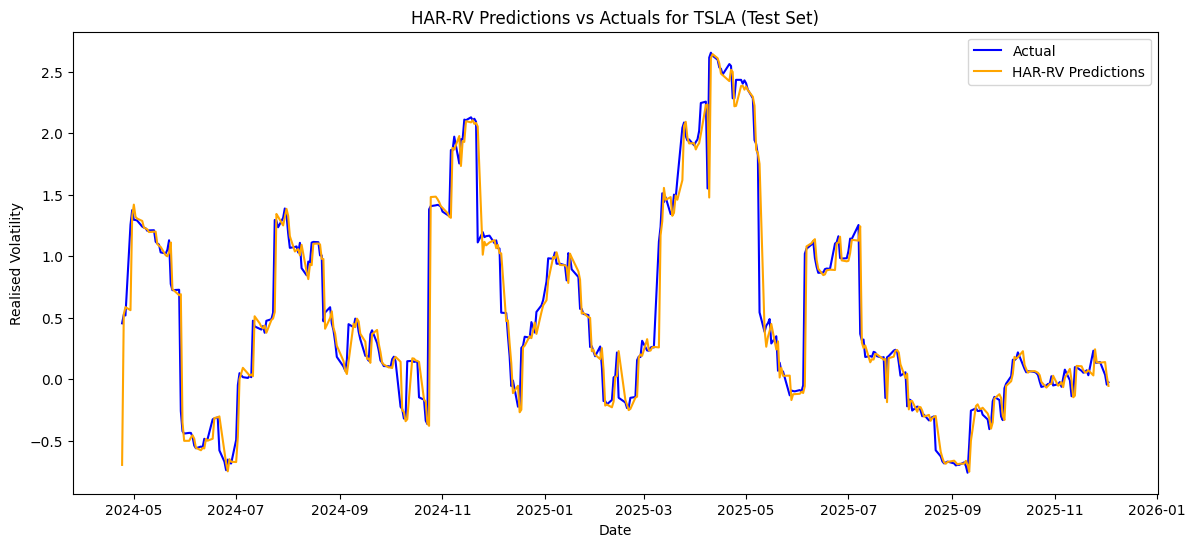

In [11]:
har_mae  = mean_absolute_error(har_test["RV"], har_preds)
har_rmse = np.sqrt(mean_squared_error(har_test["RV"], har_preds))

print(f"HAR-RV Model:")
print(f"\t'Test' MAE:  {har_mae:.6f}")
print(f"\t'Test' RMSE: {har_rmse:.6f}")

plt.figure(figsize=(14, 6))
plt.plot(har_test.index, har_test["RV"], label='Actual', color='blue')
plt.plot(har_test.index, har_preds, label='HAR-RV Predictions', color='orange')
plt.title(f'HAR-RV Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()


## 3. Machine Learning Models
### 3.1 Random Forest Regressor

In [12]:
# Prepare data for Random Forest
seq_len = 30
train_split, _, test_split = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.85,
    test_size=0.15,
)
X_train, y_train, dates_train = train_split
X_test, y_test, dates_test = test_split

# Flatten the sequences for Random Forest
n_train, seq_length, num_features = X_train.shape
X_train_rf = X_train.reshape(n_train, seq_length * num_features)
n_test = X_test.shape[0]
X_test_rf = X_test.reshape(n_test, seq_length * num_features)

[*********************100%***********************]  1 of 1 completed


Random Forest Regressor:
	Train MAE:  0.032422
	Train RMSE: 0.061415
	Test MAE:   0.115567
	Test RMSE:  0.215317


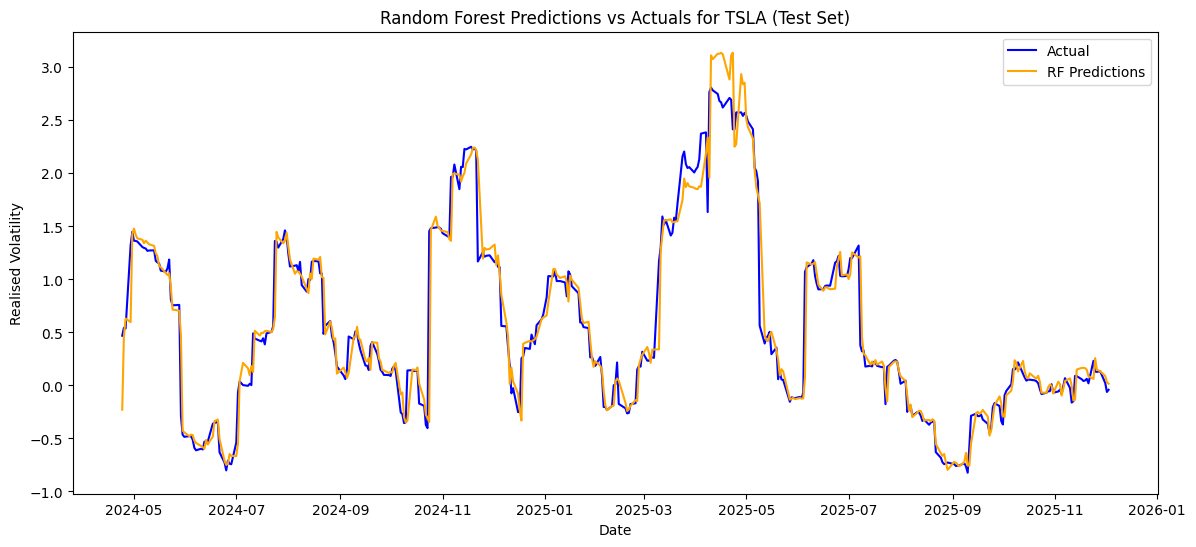

In [13]:
n_estimators = 300
rf = RandomForestRegressor(
    n_estimators=n_estimators,
    # max_depth=10,
    # min_samples_leaf=5,
    random_state=random_state,
    n_jobs=-1,
)

rf.fit(X_train_rf, y_train)

# Predict
rf_train_preds = rf.predict(X_train_rf)
rf_test_preds = rf.predict(X_test_rf)

# Evaluate
rf_train_mae = mean_absolute_error(y_train, rf_train_preds)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_preds))

rf_test_mae = mean_absolute_error(y_test, rf_test_preds)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_preds))

print(f"Random Forest Regressor:")
print(f"\tTrain MAE:  {rf_train_mae:.6f}")
print(f"\tTrain RMSE: {rf_train_rmse:.6f}")
print(f"\tTest MAE:   {rf_test_mae:.6f}")
print(f"\tTest RMSE:  {rf_test_rmse:.6f}")

# Plot predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, rf_test_preds, label='RF Predictions', color='orange')
plt.title(f'Random Forest Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

### 3.2 LSTM

In [14]:
from src.lstm import LSTMDataset

(X_train, y_train, dates_train), (X_val, y_val, dates_val), (X_test, y_test, dates_test) = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.7,
    test_size=0.15,
)

batch_size = 32
train_ds = LSTMDataset(X_train, y_train)
val_ds   = LSTMDataset(X_val,   y_val) if X_val is not None else None
test_ds  = LSTMDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False) if val_ds else None
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


In [15]:
from src.lstm import LSTMRegressor

model = LSTMRegressor(
    input_size=len(feature_cols),
    hidden_size=32,
    num_layers=1,
    dropout=0.3
    )

model_name = f"{ticker}_best_lstm_model.pth"
metrics = train_lstm(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    lr=1e-3,
    model_name=model_name
)
train_loss_history, train_rmse_history, val_loss_history, val_rmse_history, val_mase_history = metrics

model.load_state_dict(torch.load(f"../models/{model_name}"))
lstm_preds, lstm_test_mae, lstm_test_rmse = evaluate_lstm(model, test_loader, y_test)

print(f"LSTM Regressor Test MAE:  {lstm_test_mae:.6f}")
print(f"LSTM Regressor Test RMSE: {lstm_test_rmse:.6f}")

/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/100 | Train RMSE: 0.173638 | Val RMSE: 0.182314
Epoch 20/100 | Train RMSE: 0.160212 | Val RMSE: 0.156574
Epoch 30/100 | Train RMSE: 0.153413 | Val RMSE: 0.152788
Epoch 40/100 | Train RMSE: 0.146977 | Val RMSE: 0.155048
Early stopping at epoch 44. Best Val RMSE: 0.150949

Best model saved to ../models/TSLA_best_lstm_model.pth with Val RMSE: 0.150949


Training finished. Best model saved to ../models/TSLA_best_lstm_model.pth 
Best Val RMSE: 0.150949

LSTM Regressor Test MAE:  0.137448
LSTM Regressor Test RMSE: 0.217935


I tried using MASE (Mean Absolute Scaled Error) as an additional evaluation metric for the LSTM model. However, as volatility differences can be quite small, the MASE values turned out to be very large and not very informative in this context. 

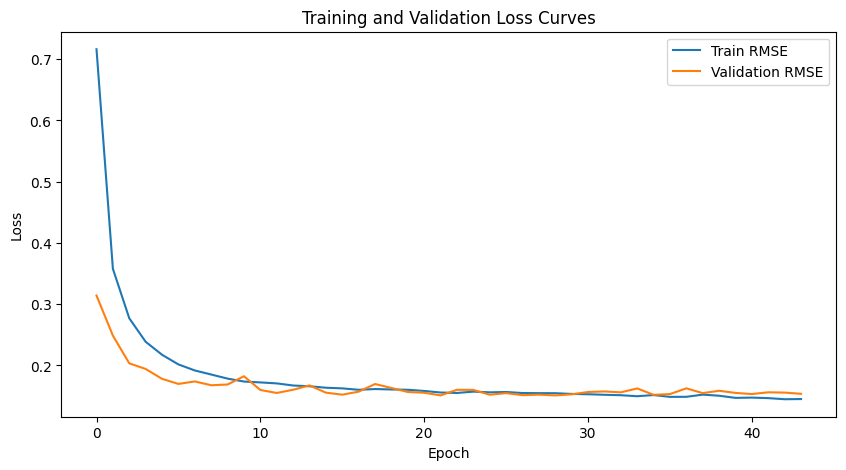

In [16]:
# Plot train and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

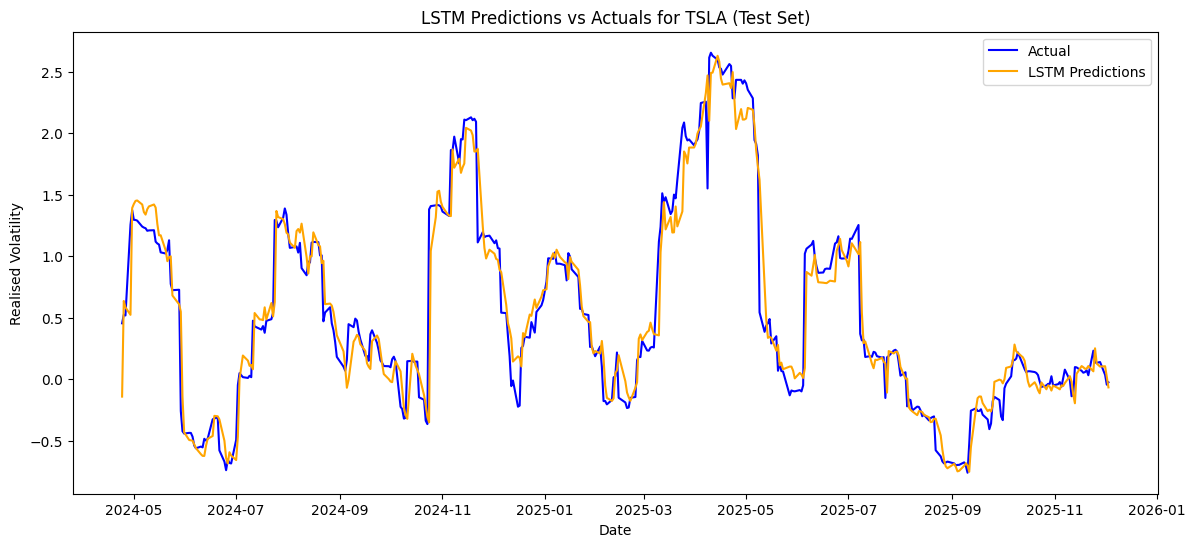

In [17]:
# Plot LSTM predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue')
plt.plot(dates_test, lstm_preds, label='LSTM Predictions', color='orange')
plt.title(f'LSTM Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

### 4. Metrics Comparison

In [18]:
# Summarize results in a DataFrame
results = pd.DataFrame({
    'Model': ['Naive Baseline', 'HAR-RV', 'Random Forest', 'LSTM Regressor'],
    'Test MAE': [base_mae, har_mae, rf_test_mae, lstm_test_mae],
    'Test RMSE': [base_rmse, har_rmse, rf_test_rmse, lstm_test_rmse],
    'MAE Ratio': [base_mae / base_mae, har_mae / base_mae, rf_test_mae / base_mae, lstm_test_mae / base_mae],
    'RMSE Ratio': [base_rmse / base_rmse, har_rmse / base_rmse, rf_test_rmse / base_rmse, lstm_test_rmse / base_rmse],
})
results

,Model,Test MAE,Test RMSE,MAE Ratio,RMSE Ratio
0,Naive Baseline,0.101513,0.217482,1.000000,1.000000
1,HAR-RV,0.103295,0.215701,1.017549,0.991814
2,Random Forest,0.115567,0.215317,1.138442,0.990047
3,LSTM Regressor,0.137448,0.217935,1.353993,1.002085


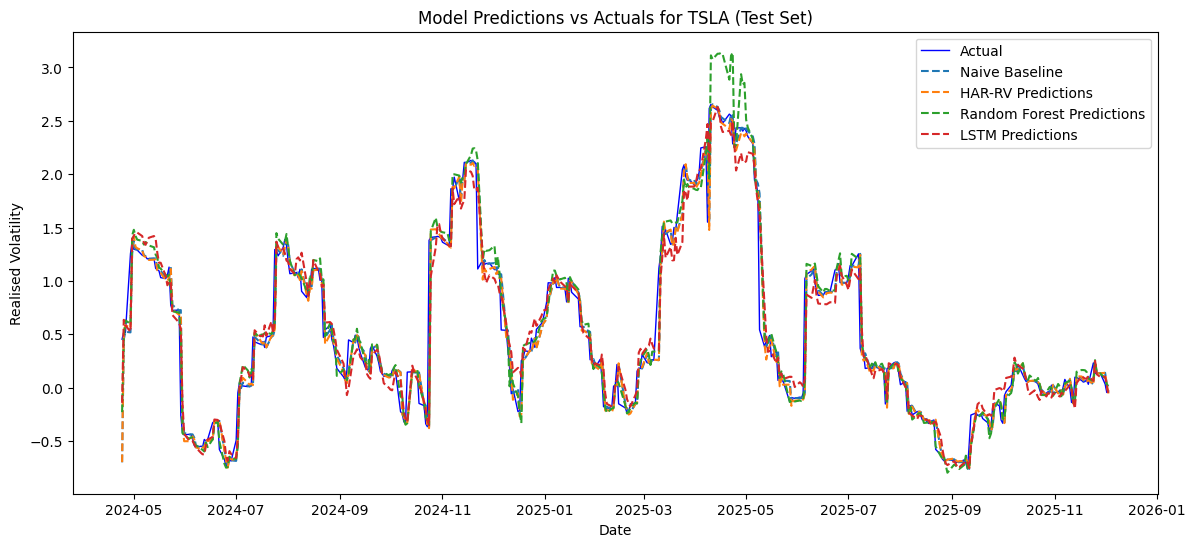

In [19]:
# Plot all model predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label='Actual', color='blue', linewidth=1)
plt.plot(dates_test, base_preds, label='Naive Baseline', linestyle='--')
plt.plot(dates_test, har_preds, label='HAR-RV Predictions', linestyle='--')
plt.plot(dates_test, rf_test_preds, label='Random Forest Predictions', linestyle='--')
plt.plot(dates_test, lstm_preds, label='LSTM Predictions', linestyle='--')
plt.title(f'Model Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

## 4. TSCV - Time Series Cross Validation

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the FULL raw dataframe
df_full = download_data(ticker, start_date=start_date)
df_full = compute_features(df_full)

# Define X and y (Raw, unscaled)
X_raw = df_full[feature_cols].values
y_raw = df_full["RealisedVolatility"].values
dates_raw = df_full.index.values

[*********************100%***********************]  1 of 1 completed


### 4.1 Random Forest Regressor

In [5]:
train_size = 22*12*3   # ~3 years
test_size = 22*12
n_folds = (len(X_raw) - train_size - seq_len) // test_size
print(n_folds)

7


In [22]:
# Best Hyperparameters found with Fixed Window TSCV
n_estimators = 300  # [100, 200, 300, 400, 500]
seq_len = 252  # [10, 30, 60, 120, 252]
# 30: 0.0555, 0.0902
# 252: 0.0508, 0.0711

rf_mae_tscv, rf_rmse_tscv = run_fixed_window_tscv(
    model_class=RandomForestRegressor,
    model_params={
        'n_estimators': n_estimators,
        'random_state': random_state,
        'n_jobs': -1
    },
    X=X_raw,
    y=y_raw,
    dates=dates_raw,
    seq_len=seq_len,
    train_size=22*12*3,
    test_size=22*12,
    verbose=False
)

--- Starting FIXED-WINDOW TSCV for RandomForestRegressor ---

Average MAE: 0.0527
Average RMSE: 0.0730


In [ ]:
#  --------------- DO NOT RUN THIS (+1H TIME) ---------------

# from utils.param_search import hyperparameter_search_rf

# best_params, best_seq_len, best_score = hyperparameter_search_rf(
#     X=X_raw,
#     y=y_raw,
#     dates=dates_raw,
#     seq_lens=[30, 60, 120, 252],
#     param_grid={
#         "n_estimators": [200, 300, 500],
#         "max_depth": [None, 10, 20],
#         "min_samples_leaf": [1, 3, 5],
#         "min_samples_split": [2, 5],
#     },
#     train_size=22 * 12 * 3,
#     test_size=22 * 12,
#     verbose=True
# )

# print("\n BEST RESULTS")
# print("Best MAE =", best_score)
# print("Best seq_len =", best_seq_len)
# print("Best parameters:", best_params)

# Best Models: MAE, RMSE - seq_len, params 
# 0.0534, 0.0879 - seq_len=30, params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 42, 'n_jobs': -1}
# 0.0534, 0.0879 - seq_len=30, params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'random_state': 42, 'n_jobs': -1}
# 0.0527, 0.0877 - seq_len=30, params={'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 42, 'n_jobs': -1}
# 0.0525, 0.0876 - seq_len=30, params={'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 42, 'n_jobs': -1}
# 0.0525, 0.0876 - seq_len=30, params={'n_estimators': 300, 'max_depth': 20,   'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 42, 'n_jobs': -1}

In [4]:
(X_train, y_train, dates_train), _, (X_test, y_test, dates_test) = load_data(
    ticker=ticker,
    feature_cols=feature_cols,
    target_col="RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.85,
    test_size=0.15,
)

# Train RF with optimal parameters on trainintg set
optimal_params = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'random_state': 42,
    'n_jobs': -1
}
rf_best = RandomForestRegressor(**optimal_params)
n_train, seq_length, num_features = X_train.shape
X_train_rf = X_train.reshape(n_train, seq_length * num_features)
n_test = X_test.shape[0]
X_test_rf = X_test.reshape(n_test, seq_length * num_features)

rf_best.fit(X_train_rf, y_train)
rf_best_test_preds = rf_best.predict(X_test_rf)

rf_best_test_mae = mean_absolute_error(y_test, rf_best_test_preds)
rf_best_test_rmse = np.sqrt(mean_squared_error(y_test, rf_best_test_preds))

print(f"Random Forest Regressor with Optimal Hyperparameters on Test Set:")
print(f"\tTest MAE:  {rf_best_test_mae:.6f}")
print(f"\tTest RMSE: {rf_best_test_rmse:.6f}")

[*********************100%***********************]  1 of 1 completed


Random Forest Regressor with Optimal Hyperparameters on Test Set:
	Test MAE:  0.117126
	Test RMSE: 0.222624


### 4.2 LSTM

In [27]:
# Best hyperparameters found
hidden_size = 64  # [32, 64, 128]
num_layers = 1  # [1, 2]
seq_len = 30  # [10, 30, 60, 120, 252]

print(f"\nLSTM TSCV Results - Hidden Size: {hidden_size}, Num Layers: {num_layers}, seq_len: {seq_len}")
lstm_mae_tscv, lstm_rmse_tscv = run_lstm_tscv(
    X=X_raw,
    y=y_raw,
    dates=dates_raw,
    seq_len=seq_len,
    n_splits=5,
    gap=30,
    lstm_params={
        "input_size": len(feature_cols),
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "dropout": 0.3,
    },
    verbose=False
)


LSTM TSCV Results - Hidden Size: 64, Num Layers: 1, seq_len: 30
--- Starting LSTM TSCV with 5 splits ---


/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.031565 | Val RMSE: 0.039080
Epoch 20/50 | Train RMSE: 0.027069 | Val RMSE: 0.035710
Epoch 30/50 | Train RMSE: 0.024751 | Val RMSE: 0.035309
Epoch 40/50 | Train RMSE: 0.023943 | Val RMSE: 0.035454
Epoch 50/50 | Train RMSE: 0.023582 | Val RMSE: 0.034868

Best model saved to ../models/lstm_tscv_fold0.pth with Val RMSE: 0.034380


Training finished. Best model saved to ../models/lstm_tscv_fold0.pth 
Best Val RMSE: 0.034380



/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.025809 | Val RMSE: 0.028690
Epoch 20/50 | Train RMSE: 0.023518 | Val RMSE: 0.032273
Epoch 30/50 | Train RMSE: 0.026314 | Val RMSE: 0.031058
Early stopping at epoch 31. Best Val RMSE: 0.028415

Best model saved to ../models/lstm_tscv_fold1.pth with Val RMSE: 0.028415


Training finished. Best model saved to ../models/lstm_tscv_fold1.pth 
Best Val RMSE: 0.028415



/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.033193 | Val RMSE: 0.111879
Epoch 20/50 | Train RMSE: 0.031037 | Val RMSE: 0.094242
Epoch 30/50 | Train RMSE: 0.030184 | Val RMSE: 0.075656
Early stopping at epoch 40. Best Val RMSE: 0.075656

Best model saved to ../models/lstm_tscv_fold2.pth with Val RMSE: 0.075656


Training finished. Best model saved to ../models/lstm_tscv_fold2.pth 
Best Val RMSE: 0.075656



/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.043261 | Val RMSE: 0.051373
Early stopping at epoch 18. Best Val RMSE: 0.044208

Best model saved to ../models/lstm_tscv_fold3.pth with Val RMSE: 0.044208


Training finished. Best model saved to ../models/lstm_tscv_fold3.pth 
Best Val RMSE: 0.044208



/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 | Train RMSE: 0.041297 | Val RMSE: 0.035243
Epoch 20/50 | Train RMSE: 0.039563 | Val RMSE: 0.039663
Epoch 30/50 | Train RMSE: 0.038536 | Val RMSE: 0.036211
Epoch 40/50 | Train RMSE: 0.037863 | Val RMSE: 0.034529
Early stopping at epoch 43. Best Val RMSE: 0.033705

Best model saved to ../models/lstm_tscv_fold4.pth with Val RMSE: 0.033705


Training finished. Best model saved to ../models/lstm_tscv_fold4.pth 
Best Val RMSE: 0.033705


=== LSTM TSCV Summary ===
Average MAE:  0.0575
Average RMSE: 0.0889


Best model: LSTM TSCV Results - Hidden Size: 64, Num Layers: 1

## 5. EXPLAINABILITY

### 5.1 SHAP

In [5]:
import shap

# Load dataa
df = download_data(ticker, start_date=start_date)
df = compute_features(df)
df_test = df.iloc[-y_test.shape[0]:]
X_test = df_test[feature_cols]

# Select a subset of X_test for SHAP analysis
X_shap = X_test.sample(n=min(500, len(X_test)), random_state=random_state)

explainer_rf = shap.TreeExplainer(rf_best)
shap_values_rf = explainer_rf.shap_values(X_shap)

shap.summary_plot(shap_values_rf, X_shap, show=True)
shap.summary_plot(shap_values_rf, X_shap, plot_type="bar", show=True)

/home/nacho/code/XAI/xai-time-series-volatility/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[*********************100%***********************]  1 of 1 completed

: 

In [ ]:
idx_max = np.argmax(shap_values_rf.mean(axis=0))
print(f"Date with highest mean absolute SHAP value for RF: {X_shap.columns[idx_max]}")